# Complexity Analysis

This notebook presents the following information, for all dataset splits - Notebooks datasets for both Software Enginnering purposes (Notebooks SE) and educational purposes (Notebooks Edu.), and Python datasets for Software Enginnering purposes (Python SE) and educational  purposes (Python Edu.), and for the Kaggle dataset:

- average cyclomatic complexity: computed for each file belonging to a given dataset split
- number of lines of code (loc): computed for each file belonging to a given dataset split
- number of code lines: computed for each file belonging to a given dataset split
- number of natural language lines: computed for each file belonging to a given dataset split. It counts the number of comment lines, and when analyzing notebooks, it also includes the number of lines in markdown cells
- ratio code to natural language: ratio, in interval 0 to 1, with the proportion of lines of code divided by number of lines of natural language. 

$ Ratio = $ total_lines_of_code  / (total_lines_of_code + markdown_lines + comment_lines) 

- statistical tests (Mann-Whitney test with effect size measure of Cohen D): to compare significant differences between the dataset splits of Python dataset and Notebook dataset.

The csv data contains one file per row.

In [1]:
import pandas as pd
import os
from pathlib import Path
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, LogFormatter, MaxNLocator, MultipleLocator
import pingouin as pg
from scipy.stats import mannwhitneyu
import numpy as np


## Auxiliar Functions

In [2]:
def get_dataframe_by_split(split: str, keep_type: str):
    """Reads the generated data for complexity analysis and filters only python and Jupyter
    notebook files to be analyzed. This function also removes files that  have errors
    during the parsing.
    If the data belongs to a Notebook data split, only .ipynb files are kept for analysis. 
    If the data belongs to a Python data split, only .py files are kept for analysis"""
    
    csv_complexity = Path(Path.cwd().parent, "complexity", "data_all_repos", (split + ".csv"))
    df_complex = pd.read_csv(csv_complexity)
    zero_complexity = df_complex.loc[df_complex['average_cyclomatic_complexity'] == 0]
    # removing files that had Lizard errors (with 0 cyclomatic complexity)
    df_complex_processed = df_complex.loc[df_complex['average_cyclomatic_complexity'] != 0]
    # including only files that could have their classes counted succesfully:
    df_complex_processed = df_complex_processed.loc[df_complex['success_counting_classes'] == True]
    print(f"Percentage of files with successful class count: {len(df_complex_processed)/len(df_complex)}")

    # getting only the files that didn't have any error during complexity computation:
    df_complex_processed = df_complex_processed.loc[df_complex_processed['errors'].isna()]
    print(f"Percentage of files without errors: {len(df_complex_processed)/len(df_complex)}")
    df_complex_processed['split'] = split
    print(f"Number of Jupyter notebooks and python files for the {split} split: {len(df_complex_processed)}")
    print(f"Percentage of files, for all file types, with 0 average cyclomatic complexity: {len(zero_complexity)/len(df_complex)}")

    df_complex_single_type = df_complex_processed.loc[df_complex_processed['file_type'] == keep_type]
    zero_complexity_single_type = df_complex_single_type.loc[df_complex_single_type['average_cyclomatic_complexity'] == 0]
    print(f"Number of {keep_type} files for the {split} split: {len(df_complex_single_type)}")
    print(f"Percentage of files, for the {keep_type} file type, with 0 average cyclomatic complexity: {len(zero_complexity_single_type)/len(df_complex_single_type)}")

    return df_complex_single_type, df_complex_processed


def ratio_code_to_natural_language(df, split):
    """Gets the ratio, on a range between 0 to 1, between total 
    lines of code divided by total lines of code, comment and/or markdown lines:
        Ratio = total lines of code / (total lines of code + markdown lines + comment lines)
    For notebooks, natural language 
    lines are defined by comments in cell codes + markdown lines.
    For python, only comment lines counts as natural language lines,
    since the markdown lines count is always 0.
    """
    # copying the dataframe to prevent modificating the original one:
    df = df.copy()
    df['natural_language'] = df['num_comment_lines'] + df['markdown_lines_count']
    df['ratio_code_natural_language'] = df['loc']/(df['natural_language'] + df['loc'])
    print(df['ratio_code_natural_language'].describe())

    df['split'] = split

    return df


def get_mann_test_and_cohen_d(df_1, df_2, column_name):
    """Applies Mann-Whitney hipothesis testing to 2 group sets
    passed as input (2 dataframe columns passed as parameter).
    Also gets Cohen D coefficient between these 2 groups,
    that is a effect size measure if two groups have similar 
    standard deviations and are of the same size 
    """
    df_1 = df_1.dropna(subset=[column_name])
    df_2 = df_2.dropna(subset=[column_name])

    statistic, p_value = mannwhitneyu(df_1[column_name], df_2[column_name])
    print(f"Mann-Whitney U statistic: {statistic}")
    # printing more decimals:
    formatted_p_value = "{:.10f}".format(p_value)
    print(f"P-value: {formatted_p_value}")
    
    # returning the absolute value of cohen d:
    cohen_d = pg.compute_effsize(df_1[column_name], df_2[column_name], eftype='cohen')
    cohen_d = np.abs(cohen_d)
    print(f"Absolute value of cohen d: {cohen_d}")
    if cohen_d <= 0.2:
        print(f"Very small difference between Notebooks vs Python (cohen D <= 0.2)")
    if cohen_d > 0.2 and cohen_d <= 0.5:
        print(f"Small difference between Notebooks vs Python ( 0.2 > cohen D <= 0.5)")
    if cohen_d > 0.5 and cohen_d <= 0.8:
        print(f"Medium difference between Notebooks vs Python ( 0.5 > cohen D <= 0.8)")
    if cohen_d > 0.8:
        print(f"Big difference between Notebooks vs Python (cohen D > 0.8)")


### Analysis of the Notebook (SE) split:

In [3]:
complexity_df_SE, complexity_df_SE_all_filetypes = get_dataframe_by_split(split="SE_nb", keep_type="notebook")


Percentage of files with successful class count: 0.8579768878902175
Percentage of files without errors: 0.8579768878902175
Number of Jupyter notebooks and python files for the SE_nb split: 42765
Percentage of files, for all file types, with 0 average cyclomatic complexity: 0.1416419227991333
Number of notebook files for the SE_nb split: 6204
Percentage of files, for the notebook file type, with 0 average cyclomatic complexity: 0.0


Number of file types (.ipynb files and .py files) for the Notebook data split for Software Engineering purposes:

In [4]:
complexity_df_SE_all_filetypes['file_type'].value_counts()

file_type
python      36561
notebook     6204
Name: count, dtype: int64

Metrics for the average cyclomatic complexity of notebooks belonging to the Software Engineer purposes split (SE), using the Lizard library:

Count, below, is the number of notebook files (.ipynb)  in the given split

In [5]:
complexity_df_SE['average_cyclomatic_complexity'].describe()

count    6204.000000
mean        4.933466
std         8.367739
min         1.000000
25%         1.000000
50%         2.000000
75%         3.600000
max        48.000000
Name: average_cyclomatic_complexity, dtype: float64

Count, below, is the number of notebook files (.ipynb)  in the given split

Lines of code (LOC) for the Notebook dataset split for Software Engineering purposes:

In [6]:
complexity_df_SE['loc'].describe()

count    6204.000000
mean      150.890393
std       184.050889
min         2.000000
25%        49.000000
50%       107.000000
75%       194.000000
max      2339.000000
Name: loc, dtype: float64

Analyzing the number of functions for the Notebook dataset split for Software Engineering purposes:

Count, below, is the number of notebook files (.ipynb)  in the given split

In [7]:
complexity_df_SE['num_functions'].describe()

count    6204.000000
mean        4.344294
std         9.602469
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max       162.000000
Name: num_functions, dtype: float64

Number of classes for the Notebook dataset split for Software Engineering purposes: 


Count, below, is the number of notebook files (.ipynb)  in the given split

In [8]:
complexity_df_SE['num_classes'].describe()

count    6204.000000
mean        0.235171
std         2.073916
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        77.000000
Name: num_classes, dtype: float64

Ratio: total lines of code (loc) divided by natural language (markdown lines + comment lines) and code lines for the Notebooks dataset for Software Engineering purposes:

$Ratio =$ total lines of code (loc) / (markdown lines + comment lines + total lines of code)

Count, below, is the number of notebook files (.ipynb)  in the given split

In [9]:
ratio_code_nl_SE = ratio_code_to_natural_language(complexity_df_SE, 'Notebook (SE)')

count    6204.000000
mean        0.652088
std         0.205463
min         0.030812
25%         0.545455
50%         0.671053
75%         0.797150
max         1.000000
Name: ratio_code_natural_language, dtype: float64


## Analysis of the Notebook (Educational) split:

In [10]:
complexity_df_non_SE, complexity_df_non_SE_all_filetypes = get_dataframe_by_split(split="Educational_nb", keep_type='notebook')

Percentage of files with successful class count: 0.8599218150870696
Percentage of files without errors: 0.8599218150870696
Number of Jupyter notebooks and python files for the Educational_nb split: 45974
Percentage of files, for all file types, with 0 average cyclomatic complexity: 0.13957316274806875
Number of notebook files for the Educational_nb split: 23765
Percentage of files, for the notebook file type, with 0 average cyclomatic complexity: 0.0


Number of notebook files (.ipynb)  in the Notebook dataset split for educational purposes:



In [11]:
complexity_df_non_SE['file_type'].value_counts()

file_type
notebook    23765
Name: count, dtype: int64

Metrics for the average cyclomatic complexity of notebooks belonging to the educational purposes split (Non SE), using the Lizard library:



Count, below, is the number of notebook files (.ipynb)  in the given split

In [12]:
complexity_df_non_SE['average_cyclomatic_complexity'].describe()

count    23765.000000
mean         1.810618
std          1.337436
min          1.000000
25%          1.000000
50%          1.333333
75%          2.000000
max         28.000000
Name: average_cyclomatic_complexity, dtype: float64

Logical lines of code (LOC) for the Notebook dataset split for educational purposes:



Count, below, is the number of notebook files (.ipynb)  in the given split

In [13]:
complexity_df_non_SE['loc'].describe()

count    23765.000000
mean       127.867705
std        165.516665
min          2.000000
25%         34.000000
50%         78.000000
75%        157.000000
max       3528.000000
Name: loc, dtype: float64

Function count, per file, for the Notebook dataset split for educational purposes:

Count, below, is the number of notebook files (.ipynb)  in the given split

In [14]:
complexity_df_non_SE['num_functions'].describe()

count    23765.000000
mean         4.352998
std          8.328939
min          1.000000
25%          1.000000
50%          1.000000
75%          5.000000
max        296.000000
Name: num_functions, dtype: float64

Number of classes, per file, for the Notebook dataset split for educational purposes:

Count, below, is the number of notebook files (.ipynb)  in the given split

In [15]:
complexity_df_non_SE['num_classes'].describe()

count    23765.000000
mean         0.275784
std          2.060854
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         81.000000
Name: num_classes, dtype: float64

Ratio total lines of code (loc) divided by natural language (markdown lines + comment lines) for educational purposes:

Count, below, is the number of notebook files (.ipynb)  in the given split

In [16]:
ratio_code_nl_non_SE = ratio_code_to_natural_language(complexity_df_non_SE, 'Notebook (Edu)')

count    23765.000000
mean         0.613415
std          0.208521
min          0.006094
25%          0.431034
50%          0.610884
75%          0.785714
max          1.000000
Name: ratio_code_natural_language, dtype: float64


### Analysis of the Python (SE) split:

In [17]:
complexity_df_SE_py, complexity_df_SE_py_all_filetypes = get_dataframe_by_split(split="SE_py", keep_type='python')

Percentage of files with successful class count: 0.87188676404156
Percentage of files without errors: 0.87188676404156
Number of Jupyter notebooks and python files for the SE_py split: 57902
Percentage of files, for all file types, with 0 average cyclomatic complexity: 0.12799277217286553
Number of python files for the SE_py split: 57412
Percentage of files, for the python file type, with 0 average cyclomatic complexity: 0.0


/tmp/ipykernel_26995/3830705784.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_complex = pd.read_csv(csv_complexity)


Analyzing the file types (.py or .ipynb) for the Python data split for Software Engineering purposes:

In [18]:
complexity_df_SE_py_all_filetypes['file_type'].value_counts()

file_type
python      57412
notebook      490
Name: count, dtype: int64

Number of lines of code (LOC) for the Python dataset split for Software Engineering purposes:

Count, below, is the number of python files (.py)  in the given split

In [19]:
complexity_df_SE_py['loc'].describe()

count     57412.000000
mean        181.068609
std        1035.351820
min           1.000000
25%          27.000000
50%          72.000000
75%         178.000000
max      218766.000000
Name: loc, dtype: float64

Number of functions, per file, for the Python dataset split for Software Engineering purposes:

Count, below, is the number of python files (.py)  in the given split

In [20]:
complexity_df_SE_py['num_functions'].describe()

count    57412.000000
mean        10.003606
std         22.094022
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max       1428.000000
Name: num_functions, dtype: float64

Number of classes, per file, for the Python dataset split for Software Engineering purposes: 


Count, below, is the number of python files (.py)  in the given split

In [21]:
complexity_df_SE_py['num_classes'].describe()

count    57412.000000
mean         1.756201
std          6.082126
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max        497.000000
Name: num_classes, dtype: float64

Ratio total lines of code (loc) divided by natural language (markdown lines + comment lines) for the Python dataset with Software Engineering purposes:


Count, below, is the number of python files (.py)  in the given split

In [22]:
ratio_code_nl_SE_py = ratio_code_to_natural_language(complexity_df_SE_py, 'Python (SE)')

count    57412.000000
mean         0.852986
std          0.167959
min          0.024390
25%          0.787636
50%          0.914286
75%          0.976744
max          1.000000
Name: ratio_code_natural_language, dtype: float64


### Analysis of the Python (Educational) split:

In [23]:
complexity_df_non_SE_py, complexity_df_non_SE_py_all_filetypes = get_dataframe_by_split(split="Educational_py", keep_type='python')

Percentage of files with successful class count: 0.8629811768695947
Percentage of files without errors: 0.8629811768695947
Number of Jupyter notebooks and python files for the Educational_py split: 5089
Percentage of files, for all file types, with 0 average cyclomatic complexity: 0.13583177887061218
Number of python files for the Educational_py split: 5048
Percentage of files, for the python file type, with 0 average cyclomatic complexity: 0.0


Number of file types (.py and .ipynb) encountered in the Python data split for educational purposes:

In [24]:
complexity_df_non_SE_py_all_filetypes['file_type'].value_counts()

file_type
python      5048
notebook      41
Name: count, dtype: int64

Average cyclomatic complexity, per file, for the Python dataset split for educational purposes:

Count, below, is the number of python files (.py)  in the given split

In [25]:
complexity_df_non_SE_py['average_cyclomatic_complexity'].describe()

count    5048.000000
mean        3.298042
std         4.126908
min         1.000000
25%         1.166667
50%         2.250000
75%         4.000000
max       108.000000
Name: average_cyclomatic_complexity, dtype: float64

Lines of code (LOC) for the Python dataset split for educational purposes:


Count, below, is the number of python files (.py)  in the given split

In [26]:
complexity_df_non_SE_py['loc'].describe()

count    5048.000000
mean      117.926704
std       248.182766
min         2.000000
25%        23.000000
50%        57.000000
75%       131.000000
max      7608.000000
Name: loc, dtype: float64

Number of functions, per file, for the Educational Python dataset split:



Count, below, is the number of python files (.py)  in the given split

In [27]:
complexity_df_non_SE_py['num_functions'].describe()

count    5048.000000
mean        6.017036
std        12.867637
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       311.000000
Name: num_functions, dtype: float64

Classes complexity for the Python Educational dataset split:


Count, below, is the number of python files (.py)  in the given split

In [28]:
complexity_df_non_SE_py['num_classes'].describe()

count    5048.000000
mean        0.882132
std         2.327414
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        57.000000
Name: num_classes, dtype: float64

Ratio total lines of code (loc) divided by natural language (markdown lines + comment lines)

Count, below, is the number of python files (.py)  in the given split

In [29]:
ratio_code_nl_non_SE_py = ratio_code_to_natural_language(complexity_df_non_SE_py, 
                                                         'Python (Edu)')

count    5048.000000
mean        0.835809
std         0.168226
min         0.045977
25%         0.752450
50%         0.888889
75%         0.967779
max         1.000000
Name: ratio_code_natural_language, dtype: float64


## Analysis of the Kaggle dataset:

In [30]:
complexity_kaggle, complexity_kaggle_all_filetypes = get_dataframe_by_split(split="Kaggle", keep_type='notebook')

Percentage of files with successful class count: 0.9229268292682927
Percentage of files without errors: 0.9229268292682927
Number of Jupyter notebooks and python files for the Kaggle split: 946
Percentage of files, for all file types, with 0 average cyclomatic complexity: 0.07707317073170732
Number of notebook files for the Kaggle split: 946
Percentage of files, for the notebook file type, with 0 average cyclomatic complexity: 0.0


Number of notebooks successfuly parsed belonging to the Kaggle dataset:

In [31]:
complexity_kaggle_all_filetypes['file_type'].value_counts()

file_type
notebook    946
Name: count, dtype: int64

Average cyclomatic complexity, per file, for the Kaggle notebooks dataset:

Count, below, is the number of notebook files (.ipynb)  in the given dataset

In [32]:
complexity_kaggle['average_cyclomatic_complexity'].describe()

count    946.000000
mean       2.496972
std        1.860042
min        1.000000
25%        1.169643
50%        2.000000
75%        3.000000
max       17.000000
Name: average_cyclomatic_complexity, dtype: float64

Logical lines of code (LOC) for the Kaggle notebooks dataset:

Count, below, is the number of notebook files (.ipynb)  in the given dataset

In [33]:
complexity_kaggle['loc'].describe()

count     946.000000
mean      173.665962
std       178.336542
min         6.000000
25%        65.250000
50%       120.000000
75%       202.000000
max      1195.000000
Name: loc, dtype: float64

Number of functions, per file, for the Kaggle notebooks dataset:

Count, below, is the number of notebook files (.ipynb)  in the given dataset

In [34]:
complexity_kaggle['num_functions'].describe()

count    946.000000
mean       4.137421
std        6.813318
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max       74.000000
Name: num_functions, dtype: float64

Number of classes, per file, for the Kaggle notebooks dataset:

Count, below, is the number of notebook files (.ipynb)  in the given dataset

In [35]:
complexity_kaggle['num_classes'].describe()

count    946.000000
mean       0.263214
std        0.982094
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       18.000000
Name: num_classes, dtype: float64

Ratio total lines of code (loc) divided by natural language (markdown lines + comment lines) for the Kaggle notebooks dataset:

Count, below, is the number of notebook files (.ipynb)  in the given dataset

In [36]:
ratio_code_nl_kaggle= ratio_code_to_natural_language(complexity_kaggle, 'Kaggle')

count    946.000000
mean       0.739831
std        0.171272
min        0.142857
25%        0.649036
50%        0.767904
75%        0.867351
max        1.000000
Name: ratio_code_natural_language, dtype: float64


Separating the data between Notebook x Python:

In [37]:
complexity_notebook = pd.concat([complexity_df_SE,
                                 complexity_df_non_SE])

complexity_python = pd.concat([complexity_df_SE_py,
                               complexity_df_non_SE_py])



all_complexity_data = pd.concat([complexity_notebook, complexity_python, complexity_kaggle])

ratio_code_nl_notebook = pd.concat([ratio_code_nl_SE, ratio_code_nl_non_SE])

ratio_code_nl_python = pd.concat([ratio_code_nl_SE_py, ratio_code_nl_non_SE_py])

all_ratio_code_nl_data = pd.concat([ratio_code_nl_notebook, ratio_code_nl_python, ratio_code_nl_kaggle])

## Statistical Tests

Using Mann-Whitney test to observe if there are any statistical significance between Notebook vs Python repositories

Statistical significance in  lines of code (loc) between Notebooks vs Python repositories:

In [38]:
get_mann_test_and_cohen_d(complexity_notebook, complexity_python, "loc")

Mann-Whitney U statistic: 1007045060.0
P-value: 0.0000000000
Absolute value of cohen d: 0.05259576784450489
Very small difference between Notebooks vs Python (cohen D <= 0.2)


Statistical significance in number of functions between Notebooks vs Python repositories:

In [39]:
get_mann_test_and_cohen_d(complexity_notebook, complexity_python, "num_functions")

Mann-Whitney U statistic: 637900466.5
P-value: 0.0000000000
Absolute value of cohen d: 0.29032299485969854
Small difference between Notebooks vs Python ( 0.2 > cohen D <= 0.5)


Statistical significance in classes complexity between Notebooks vs Python repositories:

In [40]:
get_mann_test_and_cohen_d(complexity_notebook, complexity_python, "num_classes")

Mann-Whitney U statistic: 457687283.5
P-value: 0.0000000000
Absolute value of cohen d: 0.2853965420645588
Small difference between Notebooks vs Python ( 0.2 > cohen D <= 0.5)


Statistical significance in ratio code to natural language between Notebooks vs Python repositories:

In [41]:
get_mann_test_and_cohen_d(ratio_code_nl_notebook, ratio_code_nl_python, 'ratio_code_natural_language')

Mann-Whitney U statistic: 343507508.0
P-value: 0.0000000000
Absolute value of cohen d: 1.2637321996578041
Big difference between Notebooks vs Python (cohen D > 0.8)


Statistical significance in average cyclomatic complexity between Notebooks vs Python repositories (using lizard library):

In [42]:
get_mann_test_and_cohen_d(complexity_notebook, complexity_python, 'average_cyclomatic_complexity')

Mann-Whitney U statistic: 787722473.0
P-value: 0.0000000000
Absolute value of cohen d: 0.05598957949259196
Very small difference between Notebooks vs Python (cohen D <= 0.2)


Plotting the data:

In [43]:
all_complexity_data['split'].value_counts()

split
SE_py             57412
Educational_nb    23765
SE_nb              6204
Educational_py     5048
Kaggle              946
Name: count, dtype: int64

In [44]:
# adjusitng indices only to plot the data:
all_complexity_data.reset_index(drop=True, inplace=True)

all_complexity_data['split'] = all_complexity_data['split'].map({'SE_py': 'Python (SE)', 
                                                          'Educational_nb': 'Notebook (Edu)',
                                                          'SE_nb': 'Notebook (SE)',
                                                          'Educational_py': 'Python (Edu)',
                                                          'Kaggle': 'Kaggle'})


all_ratio_code_nl_data.reset_index(drop=True, inplace=True)


Number of files belonging to each split:

In [45]:
all_complexity_data['split'].value_counts()

split
Python (SE)       57412
Notebook (Edu)    23765
Notebook (SE)      6204
Python (Edu)       5048
Kaggle              946
Name: count, dtype: int64

In [46]:
all_ratio_code_nl_data['split'].value_counts()

split
Python (SE)       57412
Notebook (Edu)    23765
Notebook (SE)      6204
Python (Edu)       5048
Kaggle              946
Name: count, dtype: int64

Plotting:

/tmp/ipykernel_26995/4104211573.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_complexity_data, x="num_functions", y="split",
/tmp/ipykernel_26995/4104211573.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_complexity_data, x="average_cyclomatic_complexity", y="split",
/tmp/ipykernel_26995/4104211573.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_complexity_data, x="loc", y="split",
/tmp/ipykernel_26995/4104211573.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

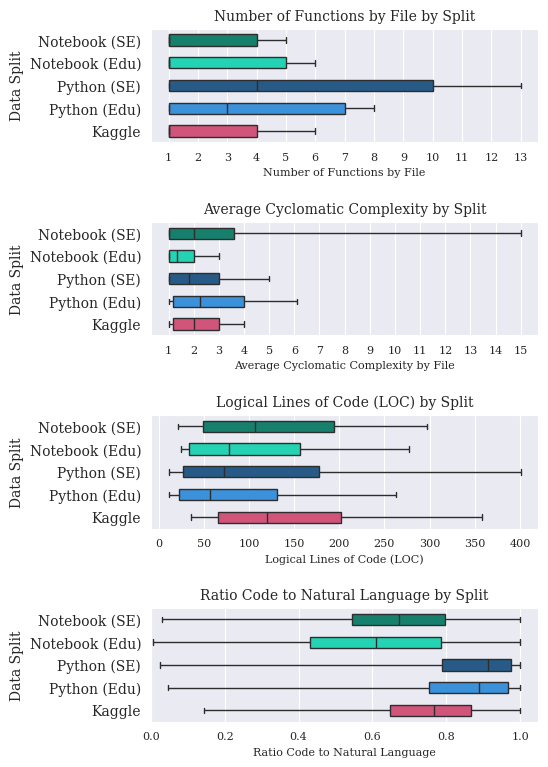

In [48]:
custom_palette = {
    'Python (SE)': '#175b96',  
    'Python (Edu)': '#2293f5',  
    'Notebook (SE)': '#069178',  
    'Notebook (Edu)': '#07f0c5',  
    'Kaggle': '#e64072' 
}
plt.rcParams['font.family'] = 'serif'

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 9))

sns.set_style("darkgrid")
sns.boxplot(data=all_complexity_data, x="num_functions", y="split", 
            palette=custom_palette, whis=(0,80), showfliers = False, width=0.5,
            ax=axs[0],boxprops=dict(alpha=1))

axs[0].tick_params(axis='x', labelsize=8)
axs[0].set_xlabel('Number of Functions by File', fontsize=8)
axs[0].set_title('Number of Functions by File by Split', fontsize=10)
axs[0].set_ylabel('Data Split', fontsize=10) 
axs[0].xaxis.set_major_locator(MultipleLocator(1))

sns.set_style("darkgrid")
sns.boxplot(data=all_complexity_data, x="average_cyclomatic_complexity", y="split", 
            palette=custom_palette, whis=(10,90), showfliers = False, width=0.5,
            ax=axs[1],boxprops=dict(alpha=1))

axs[1].tick_params(axis='x', labelsize=8)
axs[1].set_xlabel('Average Cyclomatic Complexity by File', fontsize=8)
axs[1].set_title('Average Cyclomatic Complexity by Split', fontsize=10)
axs[1].set_ylabel('Data Split', fontsize=10) 
axs[1].xaxis.set_major_locator(MultipleLocator(1))



sns.set_style("darkgrid")
sns.boxplot(data=all_complexity_data, x="loc", y="split", 
            palette=custom_palette, whis=(10,90), showfliers = False, width=0.5,
            ax=axs[2], boxprops=dict(alpha=1))

axs[2].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
axs[2].tick_params(axis='x', labelsize=8)
axs[2].set_xlabel('Logical Lines of Code (LOC)', fontsize=8)
axs[2].set_title('Logical Lines of Code (LOC) by Split', fontsize=10)
axs[2].set_ylabel('Data Split', fontsize=10)

sns.set_style("darkgrid")
sns.boxplot(data=
all_ratio_code_nl_data, x="ratio_code_natural_language", y="split", 
            palette=custom_palette,  whis=(0, 100),  showfliers = False, width = 0.5,
            ax=axs[3], boxprops=dict(alpha=1))

axs[3].set_xlabel('Ratio Code to Natural Language', fontsize=8)
axs[3].tick_params(axis='x', labelsize=8)
axs[3].set_title('Ratio Code to Natural Language by Split', fontsize=10)
axs[3].set_ylabel('Data Split', fontsize=10)
axs[3].set_xlim(left=0)

plt.subplots_adjust(hspace=0.7)
#plt.tight_layout()
plt.savefig("boxplot_complexity.pdf", format='pdf',bbox_inches='tight')
plt.show()
